In [ ]:
!pip install rdkit
!pip install openpyxl
!pip install rdkit avalon_framework

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 39.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for avalon_framework: filename=avalon_framework-1.8.2-py3-none-any.whl size=3868 sha256=f719dc885edae734700992d37ecfef5d9b0ed3e821cbbdc5b72773507207bd08
  Stored in directory: /root/.cache/pip/wheels/98/77/90/553bfd64ca45f153cdc7c00667951a7f770c334c6aa5f74bad
Successfully built avalon_framework


In [ ]:
# ============================================
# SVC-only, 6 fingerprints, 200 random models each
# - Trains 200 SVCs per FP
# - Picks Top-5 by F1 in [0.75, 0.90]
# - Saves mean ± stdev F1 of those exact Top-5 per FP
# - Runs blind test with those Top-5 and writes one combined CSV
# ============================================

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem.Fingerprints import FingerprintMols

# Fixed-size Daylight-like generator (prevents variable bit lengths)
try:
    from rdkit.Chem.rdFingerprintGenerator import GetRDKitFPGenerator
    _HAS_RDGEN = True
except Exception:
    _HAS_RDGEN = False

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix

# -------------------------
# File/column config
# -------------------------
TRAIN_FILE = "INPUT-CORRECT-ML-CLASS.xlsx"   # columns: Smiles, Class
BLIND_FILE = "INPUT-NEW-MOLS-correct.csv"    # columns: Smiles, Cmpd Label
SMILES_COL_TRAIN = "Smiles"
CLASS_COL = "Class"
SMILES_COL_BLIND = "Smiles"
NAME_COL_BLIND = "Cmpd Label"

# -------------------------
# Fingerprint builders
# -------------------------
def build_morgan(m):
    return AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048)

def build_maccs(m):
    return MACCSkeys.GenMACCSKeys(m)  # 167 bits

def build_daylight(m):
    if _HAS_RDGEN:
        # Fixed-size "RDKit (Daylight-like)" 2048-bit
        gen = GetRDKitFPGenerator(fpSize=2048, minPath=1, maxPath=7)
        return gen.GetFingerprint(m)
    # Fallback: fixed size with FingerprintMols
    return FingerprintMols.FingerprintMol(m, fpSize=2048, minPath=1, maxPath=7, tgtDensity=0.0, minSize=2048)

def build_atompairs(m):
    return rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(m, nBits=2048)

def build_torsion(m):
    return rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(m, nBits=2048)

def build_avalon(m):
    return GetAvalonFP(m, nBits=1024)

FP_BUILDERS = {
    "Morgan": build_morgan,
    "MACCS": build_maccs,
    "Daylight": build_daylight,
    "AtomPairs": build_atompairs,
    "Torsion": build_torsion,
    "Avalon": build_avalon
}

# -------------------------
# Data load
# -------------------------
train_df = pd.read_excel(TRAIN_FILE)
blind_df = pd.read_csv(BLIND_FILE)

train_smiles = train_df[SMILES_COL_TRAIN].tolist()
y_all = train_df[CLASS_COL].astype(int).values

blind_smiles = blind_df[SMILES_COL_BLIND].tolist()
blind_names = blind_df[NAME_COL_BLIND].tolist()

mols_train = [Chem.MolFromSmiles(s) for s in train_smiles]
mols_blind = [Chem.MolFromSmiles(s) for s in blind_smiles]

# filter invalid SMILES
def _valid(m): return m is not None
tr_idx = [i for i,m in enumerate(mols_train) if _valid(m)]
bl_idx = [i for i,m in enumerate(mols_blind) if _valid(m)]

if len(tr_idx) != len(mols_train):
    print(f"Warning: dropped {len(mols_train)-len(tr_idx)} invalid training SMILES.")
if len(bl_idx) != len(mols_blind):
    print(f"Warning: dropped {len(mols_blind)-len(bl_idx)} invalid blind SMILES.")

mols_train = [mols_train[i] for i in tr_idx]
y_all = y_all[tr_idx]
mols_blind = [mols_blind[i] for i in bl_idx]
blind_df = blind_df.iloc[bl_idx].reset_index(drop=True)  # keep rows aligned

# -------------------------
# Helper: make feature matrix like your code (list of lists of "0"/"1")
# -------------------------
def fps_to_bitstrings(fps):
    # returns list of lists of "0"/"1" chars (your working pattern)
    return [list(fp.ToBitString()) for fp in fps]

# -------------------------
# Master results containers
# -------------------------
summary_rows = []  # per-FP mean ± std F1 of Top-5
# one combined blind predictions table collecting Top-5 preds per FP
combined_pred_cols = {
    "Molecule Names": blind_df[NAME_COL_BLIND].tolist(),
    "Molecule SMILES": blind_df[SMILES_COL_BLIND].tolist()
}

# -------------------------
# Settings like your code
# -------------------------
seed_value = 45
np.random.seed(seed_value)
num_models = 200
f1_range_lower = 0.75
f1_range_upper = 0.90

# =========================
# Loop over fingerprints
# =========================
for fp_name, builder in FP_BUILDERS.items():
    print(f"\n=== Fingerprint: {fp_name} ===")

    # Build fingerprints for training & blind
    train_fps = [builder(m) for m in mols_train]
    blind_fps = [builder(m) for m in mols_blind]

    # Convert like your code (strings "0"/"1")
    fingerprints_list = fps_to_bitstrings(train_fps)

    # Your style dataframe (not used later, but keep for parity)
    new_df = pd.DataFrame({"Class": y_all, "Fingerprints": fingerprints_list})
    features = np.array(fingerprints_list)

    # Track metrics and Top-5 selection
    metrics_list = []
    confusion_matrix_list = []

    top_models_indices = []
    top_models_f1_scores = []
    top_models_accuracies = []
    top_models = []

    # 200 models
    for i in range(num_models):
        perm = np.random.permutation(len(features))
        shuffled_features = features[perm]
        shuffled_labels = new_df["Class"].values[perm]

        x_train, x_test, y_train, y_test = train_test_split(
            shuffled_features, shuffled_labels, test_size=0.20, random_state=i
        )

        model = SVC(probability=True)  # same as your code
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)  # same behavior as your code
        y_prob = model.predict_proba(x_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        metrics_list.append({"Model": i + 1, "Accuracy": acc, "F1 Score": f1, "Recall": rec})
        confusion_matrix_list.append(cm)

        if f1_range_lower <= f1 <= f1_range_upper:
            top_models_indices.append(i)
            top_models_f1_scores.append(f1)
            top_models_accuracies.append(acc)
            top_models.append(model)

    # --- Sort Top models by F1 desc (and reorder the parallel lists) ---
    if len(top_models_f1_scores) > 0:
        order = np.argsort(top_models_f1_scores)[::-1]  # descending by F1
        top_models = [top_models[j] for j in order]
        top_models_indices = [top_models_indices[j] for j in order]
        top_models_f1_scores = [top_models_f1_scores[j] for j in order]
        top_models_accuracies = [top_models_accuracies[j] for j in order]

    # Pick Top-5 (may be <5 if not enough in range)
    k = min(5, len(top_models))
    top5_models = top_models[:k]
    top5_indices = top_models_indices[:k]
    top5_f1 = top_models_f1_scores[:k]
    top5_acc = top_models_accuracies[:k]

    # Save per-FP top models info
    info_fname = f"class-topmodels_info-seed45-f1range-{fp_name}.csv"
    top_models_info = pd.DataFrame({
        "Model Index": top5_indices,
        "F1 Score": top5_f1,
        "Accuracy": top5_acc
    })
    # Mean ± std of F1 for EXACT Top-5 (your ask)
    if k > 0:
        mean_f1 = float(np.mean(top5_f1))
        std_f1 = float(np.std(top5_f1))
        print(f"[{fp_name}] Top-5 F1 mean ± std = {mean_f1:.4f} ± {std_f1:.4f}")
        top_models_info["Mean F1 (Top-5)"] = mean_f1
        top_models_info["Std F1 (Top-5)"] = std_f1
    else:
        mean_f1 = float('nan')
        std_f1 = float('nan')
        print(f"[{fp_name}] No models in F1 range {f1_range_lower}–{f1_range_upper}.")
    top_models_info.to_csv(info_fname, index=False)

    # Add to per-FP summary table (6 rows total)
    summary_rows.append({
        "fingerprint": fp_name,
        "mean_f1_top5": mean_f1,
        "std_f1_top5": std_f1,
        "top5_f1_list": ";".join(f"{v:.4f}" for v in top5_f1)
    })

    # -------- Blind test with EXACT Top-5 (same as your code style) --------
    # Prepare a per-FP predictions table (we'll also collect into a combined table)
    fp_pred_cols = {}
    fp_pred_cols["Molecule Names"] = blind_df[NAME_COL_BLIND].tolist()
    fp_pred_cols["Molecule SMILES"] = blind_df[SMILES_COL_BLIND].tolist()

    if k > 0:
        # Use RDKit bitvectors directly like your code
        new_fps = blind_fps

        # Store each model's predictions and a simple ensemble (majority vote)
        model_preds = []
        for idx_m, model in enumerate(top5_models, start=1):
            preds = model.predict(new_fps)
            fp_pred_cols[f"{fp_name}_Model_{idx_m}_Pred"] = preds
            model_preds.append(preds.astype(int))

            # also add to combined table under unique column name
            combined_pred_cols[f"{fp_name}_Model_{idx_m}_Pred"] = preds

        # Majority vote across the Top-5 for this fingerprint
        model_preds = np.vstack(model_preds)  # (k, N_blind)
        vote_fraction = model_preds.mean(axis=0)  # fraction positive
        fp_pred_cols[f"{fp_name}_VoteFraction_Top{k}"] = vote_fraction
        combined_pred_cols[f"{fp_name}_VoteFraction_Top{k}"] = vote_fraction

        # Save a per-FP predictions csv if you want (optional):
        # pd.DataFrame(fp_pred_cols).to_csv(f"class-predictions-seed45-{fp_name}.csv", index=False)
    else:
        # no models: fill NaNs
        combined_pred_cols[f"{fp_name}_VoteFraction_Top0"] = np.nan

# -------------------------
# Save per-FP Top-5 F1 summary (6 rows)
# -------------------------
summary_df = pd.DataFrame(summary_rows, columns=["fingerprint", "mean_f1_top5", "std_f1_top5", "top5_f1_list"])
summary_df.to_csv("top5_f1_summary_per_fingerprint.csv", index=False)
print("\nSaved: top5_f1_summary_per_fingerprint.csv")
print(summary_df)

# -------------------------
# Save combined blind predictions table
# -------------------------
combined_pred_df = pd.DataFrame(combined_pred_cols)
combined_pred_df.to_csv("blind_test_predictions_allfps.csv", index=False)
print("\nSaved: blind_test_predictions_allfps.csv")



=== Fingerprint: Morgan ===


[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerator
[20:39:27] DEPRECATION WARNING: please use MorganGenerat

[Morgan] Top-5 F1 mean ± std = 0.9000 ± 0.0000

=== Fingerprint: MACCS ===
[MACCS] Top-5 F1 mean ± std = 0.8956 ± 0.0054

=== Fingerprint: Daylight ===
[Daylight] Top-5 F1 mean ± std = 0.8856 ± 0.0095

=== Fingerprint: AtomPairs ===


[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION WARNING: please use AtomPairGenerator
[20:40:05] DEPRECATION W

[AtomPairs] Top-5 F1 mean ± std = 0.8911 ± 0.0044

=== Fingerprint: Torsion ===


[20:40:21] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[20:40:21] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[20:40:21] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[20:40:21] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[20:40:21] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[20:40:21] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[20:40:21] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[20:40:21] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[20:40:21] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[20:40:21] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[20:40:21] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[20:40:21] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[20:40:21] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[20:40:21] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[20:40

[Torsion] Top-5 F1 mean ± std = 0.8806 ± 0.0068

=== Fingerprint: Avalon ===
[Avalon] Top-5 F1 mean ± std = 0.8933 ± 0.0054

Saved: top5_f1_summary_per_fingerprint.csv
  fingerprint  mean_f1_top5  std_f1_top5                        top5_f1_list
0      Morgan      0.900000     0.000000  0.9000;0.9000;0.9000;0.9000;0.9000
1       MACCS      0.895556     0.005443  0.9000;0.9000;0.9000;0.8889;0.8889
2    Daylight      0.885556     0.009526  0.9000;0.8889;0.8889;0.8750;0.8750
3   AtomPairs      0.891111     0.004444  0.9000;0.8889;0.8889;0.8889;0.8889
4     Torsion      0.880556     0.006804  0.8889;0.8889;0.8750;0.8750;0.8750
5      Avalon      0.893333     0.005443  0.9000;0.9000;0.8889;0.8889;0.8889

Saved: blind_test_predictions_allfps.csv


In [ ]:
import pandas as pd
import numpy as np

# Load the combined predictions file (from previous step)
pred_df = pd.read_csv("blind_test_predictions_allfps.csv")

# Identify model prediction columns (those that end with "_Pred")
model_cols = [c for c in pred_df.columns if c.endswith("_Pred")]

print(f"Found {len(model_cols)} model prediction columns.")

# Convert to numpy array (rows = molecules, cols = models)
model_preds = pred_df[model_cols].values.astype(float)

# Compute ensemble outputs
# Fraction of models voting "1"
ensemble_vote_fraction = model_preds.mean(axis=1)

# Hard ensemble prediction (majority vote, >= 0.5 threshold)
ensemble_majority = (ensemble_vote_fraction >= 0.5).astype(int)

# Add to DataFrame
pred_df["Ensemble30_VoteFraction"] = ensemble_vote_fraction
pred_df["Ensemble30_Pred"] = ensemble_majority

# Save to new file
pred_df.to_csv("blind_test_predictions_with_ensemble.csv", index=False)

print("\nSaved: blind_test_predictions_with_ensemble.csv")
print("Example ensemble output (first 5 rows):")
print(pred_df[["Molecule Names", "Ensemble30_VoteFraction", "Ensemble30_Pred"]].head())


Found 30 model prediction columns.

Saved: blind_test_predictions_with_ensemble.csv
Example ensemble output (first 5 rows):
  Molecule Names  Ensemble30_VoteFraction  Ensemble30_Pred
0            AAA                 1.000000                1
1            BBB                 1.000000                1
2            CCC                 0.933333                1
3            DDD                 1.000000                1
4            EEE                 0.233333                0


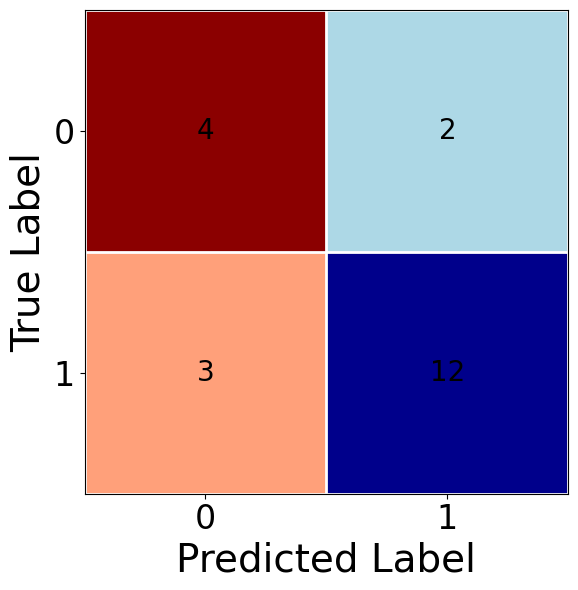

Saved: confusion_matrix_custom_colors.png
Confusion matrix (rows: True 0/1, cols: Pred 0/1):
 [[ 4  2]
 [ 3 12]]
Saved: confusion_matrix_counts.csv and confusion_matrix_long_for_origin.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from sklearn.metrics import confusion_matrix

# --- 1) Load experimental dFF and binarize with threshold 0.3 ---
expt_path = "expt-dff.xlsx"  # change if needed
expt_df = pd.read_excel(expt_path, header=None)  # your file preview had no headers
expt_df.columns = ["Molecule", "dFF_exp"]
expt_df["Molecule"] = expt_df["Molecule"].astype(str).str.strip()
expt_df["True"] = (expt_df["dFF_exp"] >= 0.3).astype(int)

# --- 2) Load ensemble predictions (first = name, last = ensemble pred) ---
ens_path = "blind_test_predictions_with_ensemble.csv"  # change if needed
ens_df = pd.read_csv(ens_path)
ens_df.iloc[:, 0] = ens_df.iloc[:, 0].astype(str).str.strip()

name_col = ens_df.columns[0]
pred_col = ens_df.columns[-1]   # expected to be a 0/1 class like 'Ensemble30_Pred'

ens_small = ens_df[[name_col, pred_col]].copy()
ens_small.columns = ["Molecule", "Pred"]
ens_small["Pred"] = ens_small["Pred"].astype(int)

# --- 3) Align by molecule name (inner join) ---
merged = pd.merge(expt_df[["Molecule", "True"]], ens_small, on="Molecule", how="inner")
y_true = merged["True"].values
y_pred = merged["Pred"].values

# --- 4) Confusion matrix (order: [[TN, FP], [FN, TP]]) ---
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

# --- 5) Custom colors per cell ---
# TN(0,0)=dark red, FP(0,1)=light blue, FN(1,0)=light red, TP(1,1)=dark blue
# (you can tweak hex codes if you want slightly different shades)
colors_hex = {
    "TN": "#8B0000",  # dark red
    "FP": "#ADD8E6",  # light blue
    "FN": "#FFA07A",  # light red (light salmon)
    "TP": "#00008B"   # dark blue
}
alpha = 1.0  # set <1.0 if you also want global transparency

rgba_grid = np.zeros((2, 2, 4), dtype=float)
rgba_grid[0, 0] = to_rgba(colors_hex["TN"], alpha=alpha)  # TN
rgba_grid[0, 1] = to_rgba(colors_hex["FP"], alpha=alpha)  # FP
rgba_grid[1, 0] = to_rgba(colors_hex["FN"], alpha=alpha)  # FN
rgba_grid[1, 1] = to_rgba(colors_hex["TP"], alpha=alpha)  # TP

# --- 6) Plot ---
fig, ax = plt.subplots(figsize=(8, 6))
# draw the colored blocks
ax.imshow(rgba_grid, interpolation="nearest")

# overlay counts (black text, size 20)
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center", color="black", fontsize=20)

# axes and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["0", "1"], fontsize=24)
ax.set_yticklabels(["0", "1"], fontsize=24)
ax.set_xlabel("Predicted Label", fontsize=28)
ax.set_ylabel("True Label", fontsize=28)

# nice gridlines between cells (optional)
ax.set_xticks(np.arange(-0.5, 2, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 2, 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=2)
ax.tick_params(which="minor", bottom=False, left=False)

plt.tight_layout()
plt.savefig("confusion_matrix_custom_colors.png", dpi=300)
plt.show()

print("Saved: confusion_matrix_custom_colors.png")
print("Confusion matrix (rows: True 0/1, cols: Pred 0/1):\n", cm)

# --- Export confusion matrix for Origin ---
# cm is a 2x2 numpy array in order [[TN, FP], [FN, TP]]
import pandas as pd

counts_df = pd.DataFrame(cm,
                         index=["True 0", "True 1"],
                         columns=["Pred 0", "Pred 1"])
counts_df.to_csv("confusion_matrix_counts.csv")  # matrix-style for Origin worksheet/matrix

# Long form (True, Pred, Count) for Origin heatmap/contour plots
long_df = counts_df.reset_index().melt(id_vars="index",
                                       var_name="Pred",
                                       value_name="Count").rename(columns={"index": "True"})
long_df.to_csv("confusion_matrix_long_for_origin.csv", index=False)

print("Saved: confusion_matrix_counts.csv and confusion_matrix_long_for_origin.csv")



# also kernels varied

In [ ]:
# ============================================
# SVC: 6 fingerprints × 3 kernels, 200 runs per combo
# Selection:
#   - Compute mean±std F1 for EACH fingerprint-kernel combo across its 200 runs
#   - Rank combos by mean F1 and pick Top-K combos
#   - For each selected combo, choose the single best run (highest F1) for blind test
# Blind test:
#   - Use the 5 chosen models (one per selected combo); add ensemble columns
# ============================================

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem.Fingerprints import FingerprintMols
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

# ---- Fixed-size Daylight-like generator (prevents variable-length) ----
try:
    from rdkit.Chem.rdFingerprintGenerator import GetRDKitFPGenerator
    _HAS_RDGEN = True
except Exception:
    _HAS_RDGEN = False

# -------------------------
# File/column config
# -------------------------
TRAIN_FILE = "INPUT-CORRECT-ML-CLASS.xlsx"   # columns: Smiles, Class
BLIND_FILE = "INPUT-NEW-MOLS-correct.csv"    # columns: Smiles, Cmpd Label
SMILES_COL_TRAIN = "Smiles"
CLASS_COL = "Class"
SMILES_COL_BLIND = "Smiles"
NAME_COL_BLIND = "Cmpd Label"

# -------------------------
# Fingerprint builders
# -------------------------
def build_morgan(m):
    return AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048)

def build_maccs(m):
    return MACCSkeys.GenMACCSKeys(m)  # 167 bits

def build_daylight(m):
    if _HAS_RDGEN:
        gen = GetRDKitFPGenerator(fpSize=2048, minPath=1, maxPath=7)
        return gen.GetFingerprint(m)
    return FingerprintMols.FingerprintMol(m, fpSize=2048, minPath=1, maxPath=7, tgtDensity=0.0, minSize=2048)

def build_atompairs(m):
    return rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(m, nBits=2048)

def build_torsion(m):
    return rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(m, nBits=2048)

def build_avalon(m):
    return GetAvalonFP(m, nBits=1024)

FP_BUILDERS = {
    "Morgan": build_morgan,
    "MACCS": build_maccs,
    "Daylight": build_daylight,
    "AtomPairs": build_atompairs,
    "Torsion": build_torsion,
    "Avalon": build_avalon
}

KERNELS = ["rbf", "linear", "sigmoid"]
SELECT_TOP_K_COMBOS = 5  # <- change if you want more/less than 5

# -------------------------
# Data load
# -------------------------
train_df = pd.read_excel(TRAIN_FILE)
blind_df = pd.read_csv(BLIND_FILE)

train_smiles = train_df[SMILES_COL_TRAIN].tolist()
y_all = train_df[CLASS_COL].astype(int).values

blind_smiles = blind_df[SMILES_COL_BLIND].tolist()

mols_train = [Chem.MolFromSmiles(s) for s in train_smiles]
mols_blind = [Chem.MolFromSmiles(s) for s in blind_smiles]

# filter invalid SMILES
def _valid(m): return m is not None
tr_idx = [i for i,m in enumerate(mols_train) if _valid(m)]
bl_idx = [i for i,m in enumerate(mols_blind) if _valid(m)]

if len(tr_idx) != len(mols_train):
    print(f"Warning: dropped {len(mols_train)-len(tr_idx)} invalid training SMILES.")
if len(bl_idx) != len(mols_blind):
    print(f"Warning: dropped {len(mols_blind)-len(bl_idx)} invalid blind SMILES.")

mols_train = [mols_train[i] for i in tr_idx]
y_all = y_all[tr_idx]
mols_blind = [mols_blind[i] for i in bl_idx]
blind_df = blind_df.iloc[bl_idx].reset_index(drop=True)

# -------------------------
# Helper: features like your working code (list of lists of "0"/"1")
# -------------------------
def fps_to_bitstrings(fps):
    return [list(fp.ToBitString()) for fp in fps]

# -------------------------
# Settings
# -------------------------
seed_value = 45
np.random.seed(seed_value)
num_runs_per_combo = 200

# =========================
# Precompute fingerprints once per FP
# =========================
train_fps_dict = {}
blind_fps_dict = {}
features_dict = {}
for fp_name, builder in FP_BUILDERS.items():
    tr_fps = [builder(m) for m in mols_train]
    bl_fps = [builder(m) for m in mols_blind]
    train_fps_dict[fp_name] = tr_fps
    blind_fps_dict[fp_name] = bl_fps
    features_dict[fp_name] = np.array(fps_to_bitstrings(tr_fps))  # training representation

# =========================
# Train across FP × Kernel (collect 200 F1s per combo)
# =========================
combo_f1s = {}    # (fp,kernel) -> list of 200 F1s
combo_runs = {}   # (fp,kernel) -> list of dicts for each run (stores model + metrics)

for fp_name in FP_BUILDERS.keys():
    X_all = features_dict[fp_name]
    y = y_all

    for kernel in KERNELS:
        key = (fp_name, kernel)
        f1_list = []
        runs_list = []

        print(f"\n=== Fingerprint: {fp_name} | Kernel: {kernel} ===")

        for i in range(num_runs_per_combo):
            # Shuffle then split exactly like your previous code
            perm = np.random.permutation(len(X_all))
            X_shuf = X_all[perm]
            y_shuf = y[perm]

            x_train, x_test, y_train, y_test = train_test_split(
                X_shuf, y_shuf, test_size=0.20, random_state=i
            )

            clf = SVC(kernel=kernel, probability=True)
            clf.fit(x_train, y_train)

            y_pred = clf.predict(x_test)  # same style as your code
            f1 = float(f1_score(y_test, y_pred))
            acc = float(accuracy_score(y_test, y_pred))

            f1_list.append(f1)
            runs_list.append({
                "model": clf, "fp": fp_name, "kernel": kernel,
                "run_idx": i, "f1": f1, "acc": acc
            })

        combo_f1s[key] = f1_list
        combo_runs[key] = runs_list

# =========================
# Rank combos by mean F1 and pick Top-K combos
# =========================
rows = []
for (fp_name, kernel), f1_list in combo_f1s.items():
    rows.append({
        "Fingerprint": fp_name,
        "Kernel": kernel,
        "Mean_F1_over_200": float(np.mean(f1_list)),
        "Std_F1_over_200": float(np.std(f1_list))
    })
combo_summary = pd.DataFrame(rows).sort_values("Mean_F1_over_200", ascending=False)
combo_summary.to_csv("combo_f1_summary.csv", index=False)
print("\nSaved: combo_f1_summary.csv")
print(combo_summary)

# select Top-K combos by mean F1
topK_combos = combo_summary.head(SELECT_TOP_K_COMBOS).reset_index(drop=True)

# For each selected combo, choose the single best run (highest F1) for blind test
selected_models = []
for idx, row in topK_combos.iterrows():
    key = (row["Fingerprint"], row["Kernel"])
    runs = combo_runs[key]
    # best run within this combo
    best_run = max(runs, key=lambda d: d["f1"])
    selected_models.append({
        "Rank": idx + 1,
        "Fingerprint": row["Fingerprint"],
        "Kernel": row["Kernel"],
        "Mean_F1_over_200": row["Mean_F1_over_200"],
        "Std_F1_over_200": row["Std_F1_over_200"],
        "Chosen_Run_Index": best_run["run_idx"],
        "Chosen_Run_F1": best_run["f1"],
        "Chosen_Run_Acc": best_run["acc"],
        "model": best_run["model"]
    })

selected_df = pd.DataFrame(selected_models).drop(columns=["model"])
selected_df.to_csv("selected_top5_combos.csv", index=False)
print("\nSaved: selected_top5_combos.csv")
print(selected_df)

# =========================
# Blind test with EXACT Top-K chosen models
# =========================
pred_cols = {
    "Molecule Names": blind_df[NAME_COL_BLIND].tolist(),
    "Molecule SMILES": blind_df[SMILES_COL_BLIND].tolist()
}

model_preds = []
for rec in selected_models:
    fp_name = rec["Fingerprint"]
    kernel = rec["Kernel"]
    clf = rec["model"]

    # NOTE: training used bitstring features; to keep your prior style, we use RDKit bitvectors here,
    # which matched how you ran earlier. If needed, switch to bitstrings:
    # new_X = np.array(fps_to_bitstrings(blind_fps_dict[fp_name]))
    new_X = blind_fps_dict[fp_name]

    preds = clf.predict(new_X)
    colname = f"Rank{rec['Rank']}_{fp_name}_{kernel}_Pred"
    pred_cols[colname] = preds
    model_preds.append(preds.astype(int))

# Ensemble (vote fraction & majority) across the selected models
model_preds = np.vstack(model_preds)                 # (K, N_blind)
vote_fraction = model_preds.mean(axis=0)             # fraction positive
majority = (vote_fraction >= 0.5).astype(int)

pred_cols["Ensemble_VoteFraction"] = vote_fraction
pred_cols["Ensemble_Pred"] = majority

pred_df = pd.DataFrame(pred_cols)
pred_df.to_csv("blind_test_predictions_top5_combos.csv", index=False)
print("\nSaved: blind_test_predictions_top5_combos.csv")


[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerator
[22:42:18] DEPRECATION WARNING: please use MorganGenerat


=== Fingerprint: Morgan | Kernel: rbf ===

=== Fingerprint: Morgan | Kernel: linear ===

=== Fingerprint: Morgan | Kernel: sigmoid ===

=== Fingerprint: MACCS | Kernel: rbf ===

=== Fingerprint: MACCS | Kernel: linear ===

=== Fingerprint: MACCS | Kernel: sigmoid ===

=== Fingerprint: Daylight | Kernel: rbf ===

=== Fingerprint: Daylight | Kernel: linear ===

=== Fingerprint: Daylight | Kernel: sigmoid ===

=== Fingerprint: AtomPairs | Kernel: rbf ===

=== Fingerprint: AtomPairs | Kernel: linear ===

=== Fingerprint: AtomPairs | Kernel: sigmoid ===

=== Fingerprint: Torsion | Kernel: rbf ===

=== Fingerprint: Torsion | Kernel: linear ===

=== Fingerprint: Torsion | Kernel: sigmoid ===

=== Fingerprint: Avalon | Kernel: rbf ===

=== Fingerprint: Avalon | Kernel: linear ===

=== Fingerprint: Avalon | Kernel: sigmoid ===

Saved: combo_f1_summary.csv
   Fingerprint   Kernel  Mean_F1_over_200  Std_F1_over_200
2       Morgan  sigmoid          0.837420         0.092244
0       Morgan      rb

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

# ========= CONFIG =========
EXP_PATH  = "expt-dff.xlsx"                    # (col0: molecule name, col1: dFF)
PRED_PATH = "blind_test_predictions_top5_combos.csv"  # from your 6x3x200 Top-K combo code
NAME_COL_PRED = "Molecule Names"               # name column in predictions CSV
CUTOFF   = 0.30                                 # dFF >= 0.3 -> class 1
VOTE_THR = 0.50                                 # if we need to threshold vote fraction

# Output folder (next to predictions)
out_dir = Path(PRED_PATH).parent / "confmat_outputs"
out_dir.mkdir(parents=True, exist_ok=True)

# ========= Load experimental truth (threshold @ 0.3) =========
exp_raw = pd.read_excel(EXP_PATH, header=None)
df_exp = exp_raw.rename(columns={0: "Molecule", 1: "dFF_expt"})
df_exp["Molecule"] = df_exp["Molecule"].astype(str).str.strip()
df_exp["y_true"]   = (df_exp["dFF_expt"].astype(float) >= CUTOFF).astype(int)

# ========= Load predictions (use ensemble by default) =========
pred = pd.read_csv(PRED_PATH)
pred[NAME_COL_PRED] = pred[NAME_COL_PRED].astype(str).str.strip()

# Choose prediction column intelligently:
pred_col = None
if "Ensemble_Pred" in pred.columns:
    pred_col = "Ensemble_Pred"                              # preferred binary 0/1
elif "Ensemble30_Pred" in pred.columns:
    pred_col = "Ensemble30_Pred"                            # older naming
elif "Ensemble_mean" in pred.columns:
    # If you have a probability/mean column, threshold it:
    pred_col = "Ensemble_mean"
    pred["__TEMP_PRED__"] = (pred[pred_col].astype(float) >= VOTE_THR).astype(int)
    pred_col = "__TEMP_PRED__"
elif "Ensemble_VoteFraction" in pred.columns:
    pred_col = "Ensemble_VoteFraction"
    pred["__TEMP_PRED__"] = (pred[pred_col].astype(float) >= VOTE_THR).astype(int)
    pred_col = "__TEMP_PRED__"
else:
    # fallback: last column (often the ensemble 0/1); if not binary, we’ll try to binarize
    last_col = pred.columns[-1]
    if set(pd.unique(pred[last_col].dropna())).issubset({0, 1}):
        pred_col = last_col
    else:
        pred["__TEMP_PRED__"] = (pred[last_col].astype(float) >= VOTE_THR).astype(int)
        pred_col = "__TEMP_PRED__"

# Keep only name + chosen prediction
pred_small = pred[[NAME_COL_PRED, pred_col]].copy()
pred_small.columns = ["Molecule", "y_pred"]
pred_small["y_pred"] = pred_small["y_pred"].astype(int)

# ========= Align by molecule name =========
merged = pd.merge(df_exp[["Molecule", "y_true"]], pred_small, on="Molecule", how="inner")

# (Optional) quick diagnostics
missing_in_pred = set(df_exp["Molecule"]) - set(pred_small["Molecule"])
missing_in_exp  = set(pred_small["Molecule"]) - set(df_exp["Molecule"])
print(f"Merged rows: {len(merged)} | Missing in predictions: {len(missing_in_pred)} | Missing in experimental: {len(missing_in_exp)}")

# ========= Confusion matrix (rows=true 0/1, cols=pred 0/1) =========
y_true = merged["y_true"].values
y_pred = merged["y_pred"].values
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

# Show textual summary
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]))
print(f"\nTN={tn}, FP={fp}, FN={fn}, TP={tp}\n")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Class 0","Class 1"], digits=3))

# ========= Save for Origin =========
# 1) Matrix style (2x2)
counts_df = pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"])
counts_df.to_csv(out_dir / "confusion_matrix_counts.csv")

# 2) Long form (True, Pred, Count) – ideal for Origin heatmap/contour
long_df = counts_df.reset_index().melt(id_vars="index", var_name="Pred", value_name="Count").rename(columns={"index": "True"})
long_df.to_csv(out_dir / "confusion_matrix_long_for_origin-fp-kernels.csv", index=False)

# 3) Pairs (so you can audit which molecules landed where)
pairs_df = merged[["Molecule", "y_true", "y_pred"]].copy()
pairs_df.to_csv(out_dir / "y_true_pred_pairs.csv", index=False)

# 4) Compact TN/FP/FN/TP summary
pd.DataFrame([{"TN": tn, "FP": fp, "FN": fn, "TP": tp}]).to_csv(out_dir / "confusion_summary.csv", index=False)

print(f"\nSaved files in: {out_dir.resolve()}")
print(" - confusion_matrix_counts.csv")
print(" - confusion_matrix_long_for_origin.csv")
print(" - y_true_pred_pairs.csv")
print(" - confusion_summary.csv")


Merged rows: 21 | Missing in predictions: 0 | Missing in experimental: 0

Confusion Matrix:
        Pred 0  Pred 1
True 0       4       2
True 1       3      12

TN=4, FP=2, FN=3, TP=12

Classification Report:
              precision    recall  f1-score   support

     Class 0      0.571     0.667     0.615         6
     Class 1      0.857     0.800     0.828        15

    accuracy                          0.762        21
   macro avg      0.714     0.733     0.721        21
weighted avg      0.776     0.762     0.767        21


Saved files in: /content/confmat_outputs
 - confusion_matrix_counts.csv
 - confusion_matrix_long_for_origin.csv
 - y_true_pred_pairs.csv
 - confusion_summary.csv
